In [80]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Define service categories and weights
categories = [
    "topup", "household_bill", "internet_payment",
    "bank_withdrawal", "bank_deposit", "insurance_payment", "school_fee",
    "airline_ticket", "movie_ticket", "credit_card_payment", "online_shopping", "tax_payment",
    "loan_repayment", "govt_fee", "mobile_data_pack"
]
weights = [
    10, 8, 7,
    5, 5, 4, 6,
    2, 3, 4, 7, 3,
    5, 2, 6
]

# Define festivals with month and day only
festivals = {
    "New Year Nepali": ("04-13", 3),
    "New Year English": ("01-01", 2.5),
    "Mother's Day": ("05-09", 1.5),
    "Buddha Jayanti": ("05-13", 1.8),
    "Teej": ("08-26", 2),
    "Indra Jatra": ("09-05", 1.5),
    "Dashain Day 1": ("10-05", 3),
    "Dashain Day 2": ("10-06", 3),
    "Dashain Day 3": ("10-07", 3),
    "Dashain Day 4": ("10-08", 3),
    "Dashain Day 5": ("10-09", 3),
    "Tihar Day 1": ("11-01", 3),
    "Tihar Day 2": ("11-02", 3),
    "Tihar Day 3": ("11-03", 3),
    "Tihar Day 4": ("11-04", 3),
    "Chhath": ("11-09", 2),
    "Christmas": ("12-25", 1.5),
    "Maghe Sankranti": ("01-14", 1.7),
    "Shivaratri": ("02-26", 2.5),
    "Holi": ("03-06", 2.8),
    "Valentine's Day": ("02-14", 2),
    "Rakhshya Bandhan": ("08-09", 1.5)
}

# Generate date range for 3 years
start_date = datetime.strptime("2022-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2025-01-01", "%Y-%m-%d")
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Get festival info
def get_festival_info(date):
    month_day = date.strftime("%m-%d")
    for fest, (f_date, multiplier) in festivals.items():
        if month_day == f_date:
            return True, fest, multiplier
    return False, "", 1

# Additive trend factor based on days passed
def get_trend_factors(date):
    days_passed = (date - start_date).days
    amount_trend = 0.3 * days_passed / 365  # ~2% increase per year
    volume_trend = 0.15 * days_passed / 365  # ~3% increase per year
    return amount_trend, volume_trend

# Generate dataset
data = []
for date in date_range:
    is_fest, fest_name, multiplier = get_festival_info(date)
    is_holiday = is_fest or date.weekday() == 6
    amount_trend, volume_trend = get_trend_factors(date)
    base_txns = random.randint(50, 100)
    num_txns = int(base_txns * (1 + volume_trend) * multiplier)

    for _ in range(num_txns):
        service = random.choices(categories, weights=weights, k=1)[0]
        base_amount = np.random.randint(50, 5000)
        final_amount = base_amount * (1 + amount_trend) * random.uniform(1.0, multiplier)
        data.append([
            date.strftime("%Y-%m-%d"),
            service,
            round(final_amount, 2),
            is_fest,
            fest_name,
            is_holiday
        ])

# Convert to DataFrame
df = pd.DataFrame(data, columns=[
    "transaction_date", "service_category", "amount", "is_festival", "festival_name", "is_holiday"
])

# Display summary
df.head(), len(df)


(  transaction_date  service_category   amount  is_festival     festival_name  \
 0       2022-01-01    loan_repayment  5418.33         True  New Year English   
 1       2022-01-01        school_fee  4199.33         True  New Year English   
 2       2022-01-01  internet_payment  6711.15         True  New Year English   
 3       2022-01-01          govt_fee  3510.30         True  New Year English   
 4       2022-01-01  internet_payment  5798.36         True  New Year English   
 
    is_holiday  
 0        True  
 1        True  
 2        True  
 3        True  
 4        True  ,
 110277)

In [79]:
df.to_csv('./synthetic_data.csv', index=False)

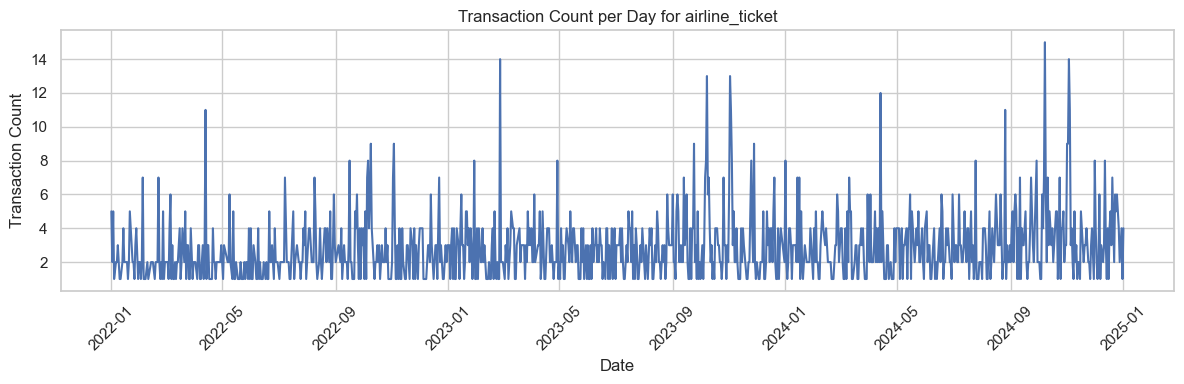

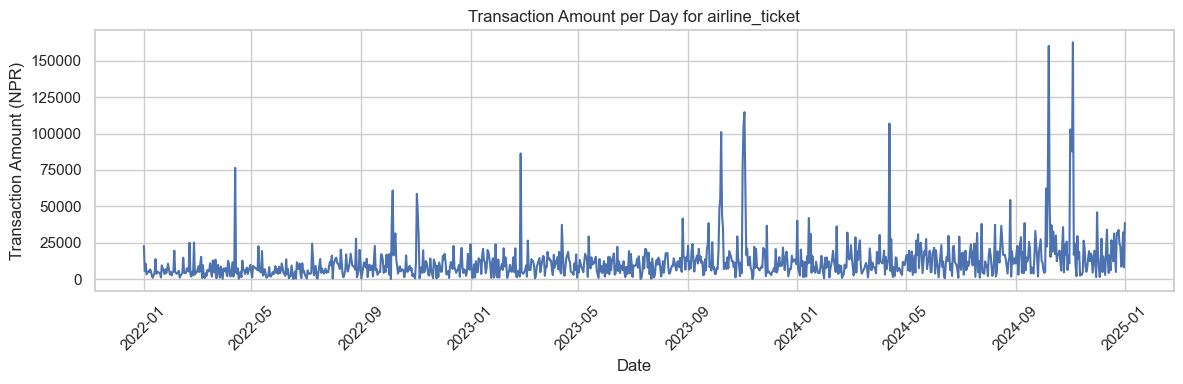

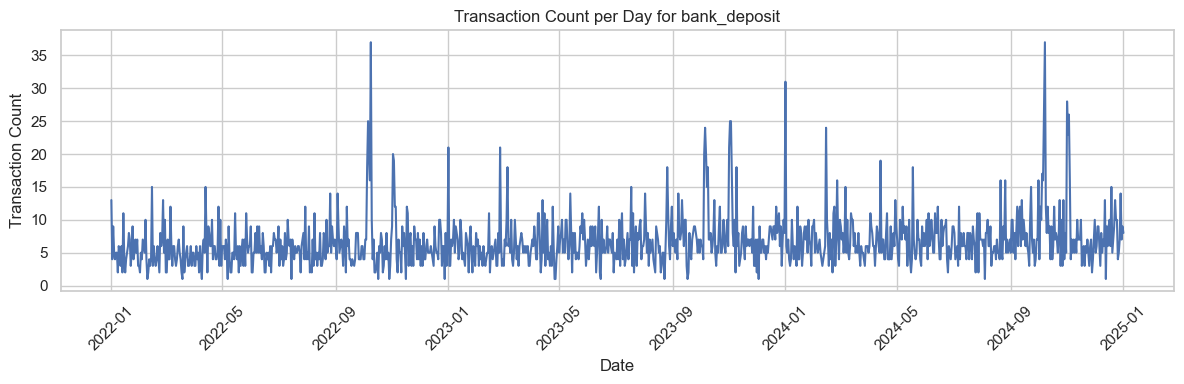

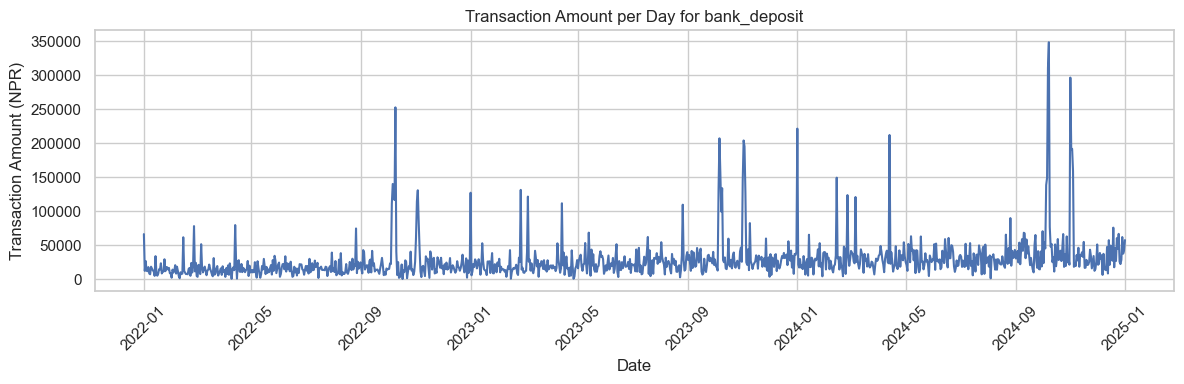

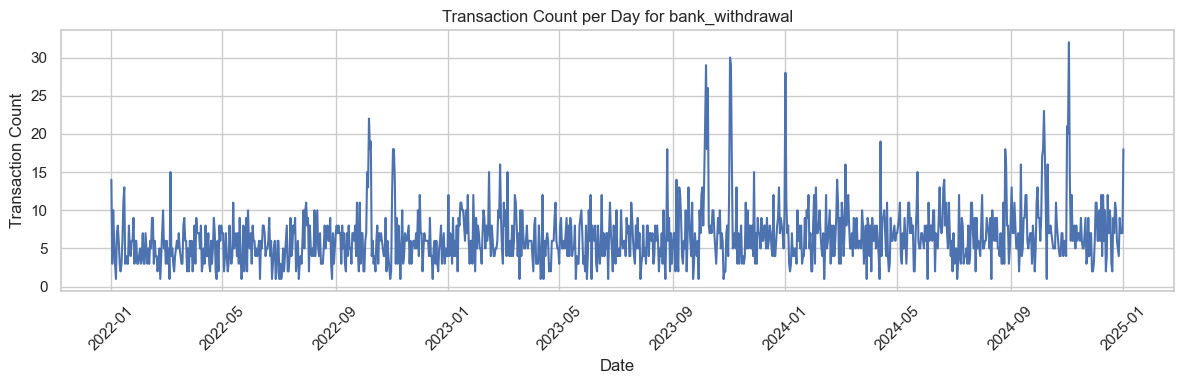

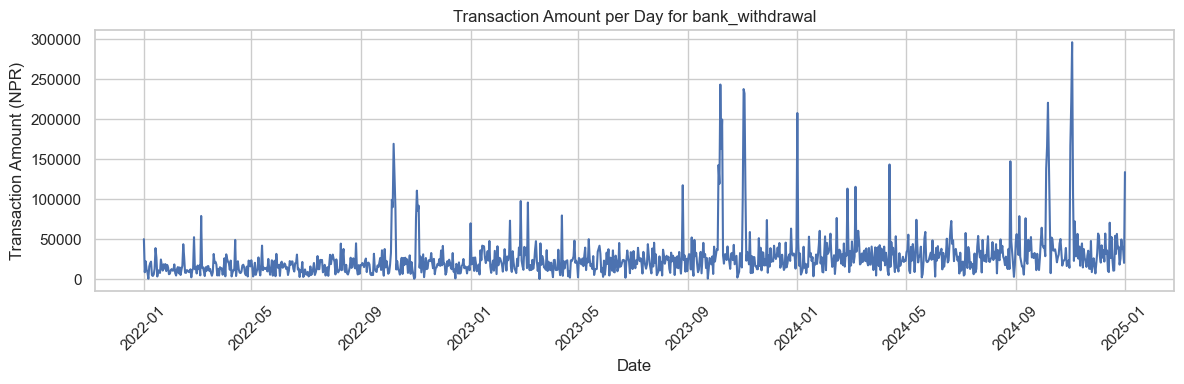

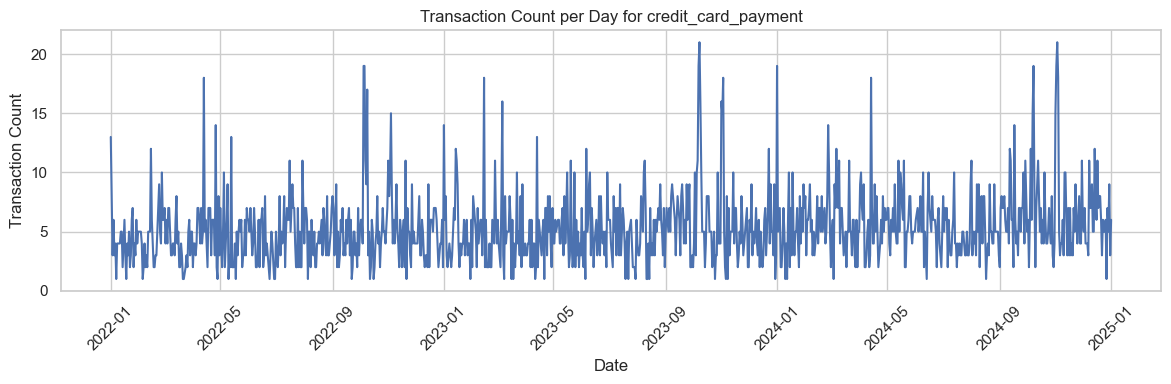

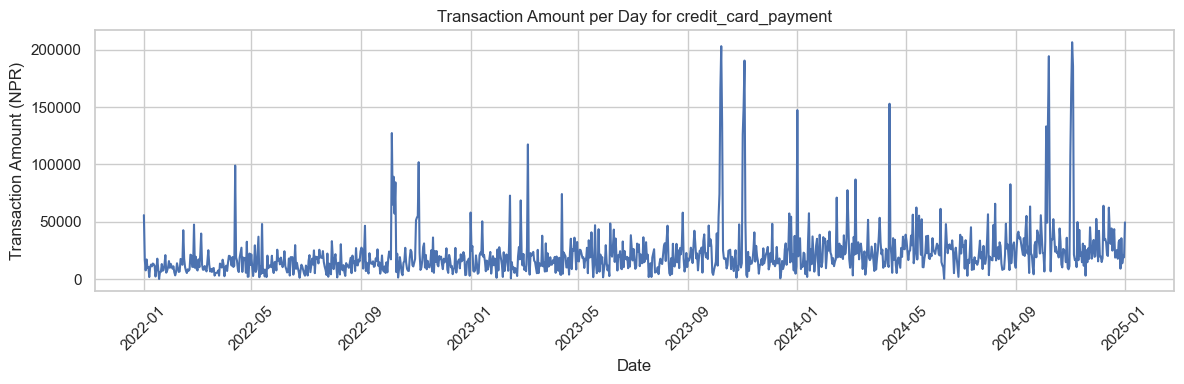

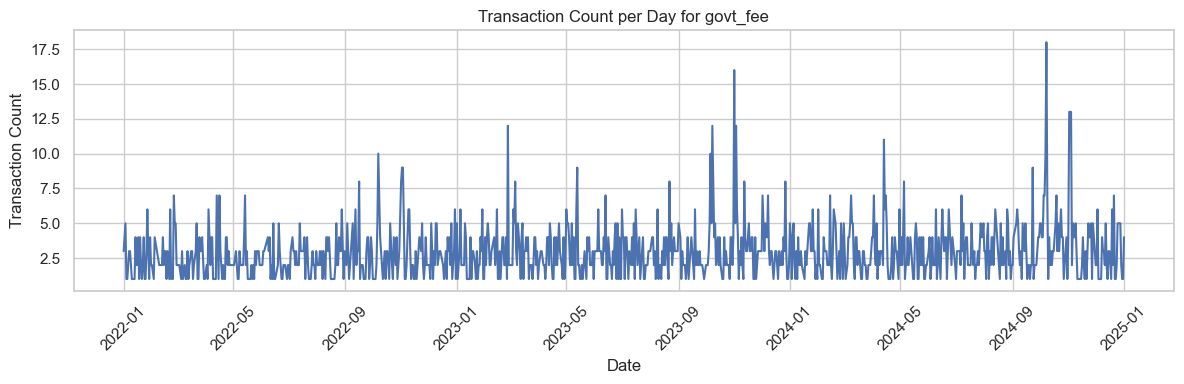

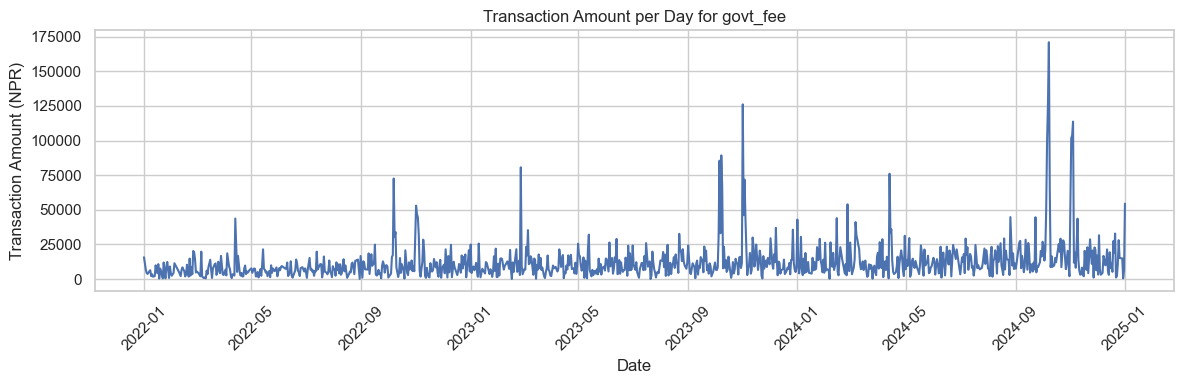

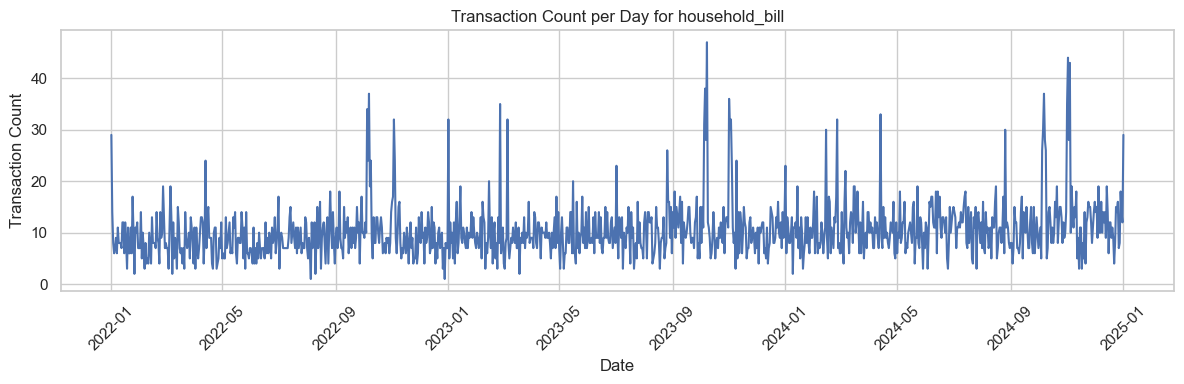

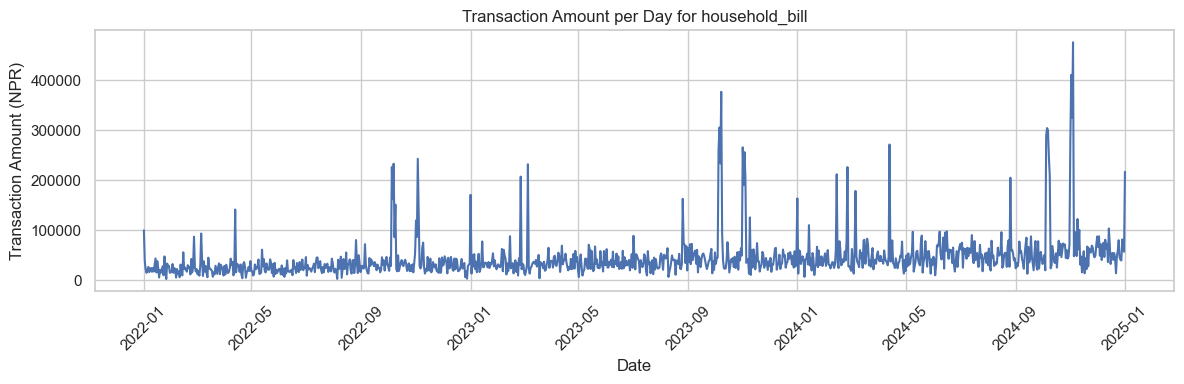

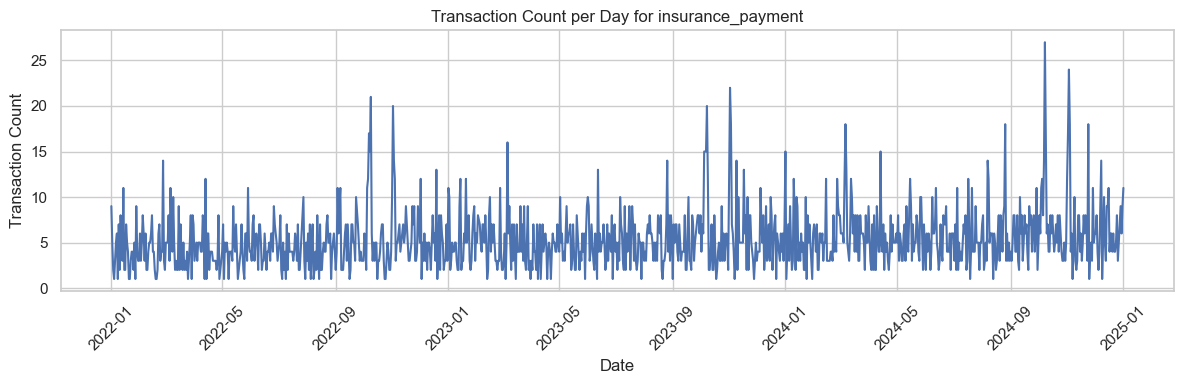

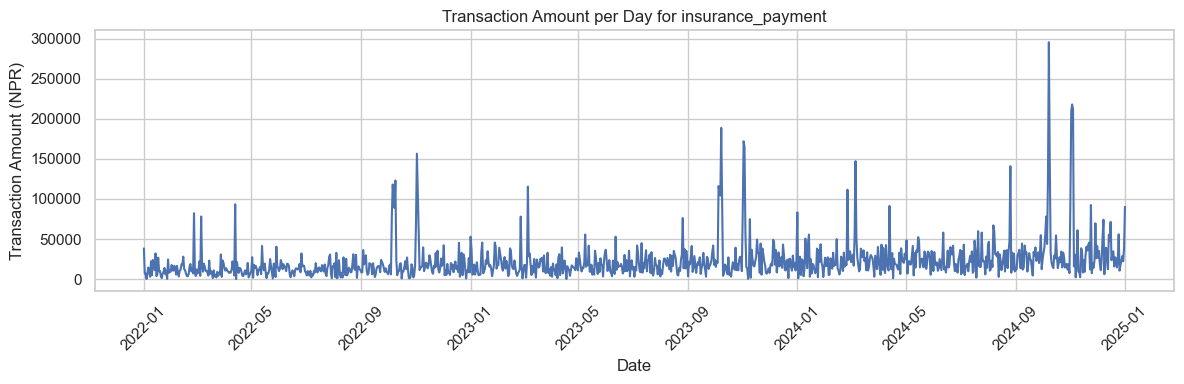

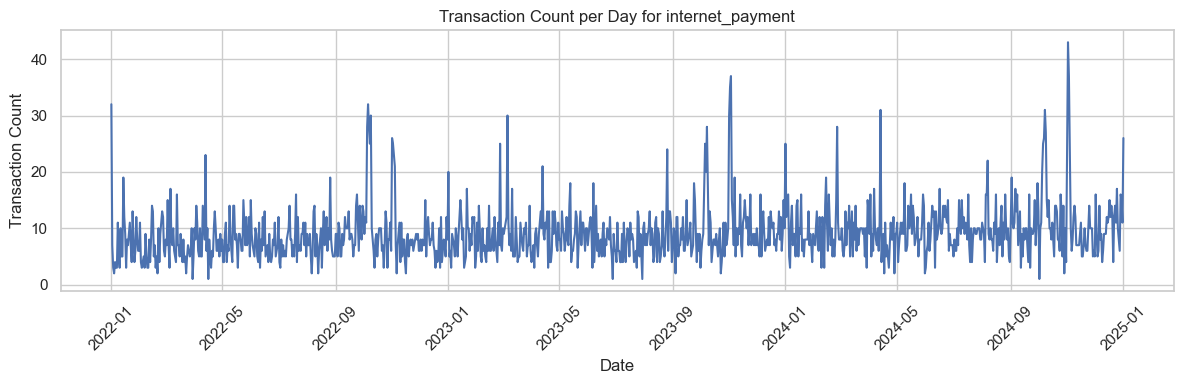

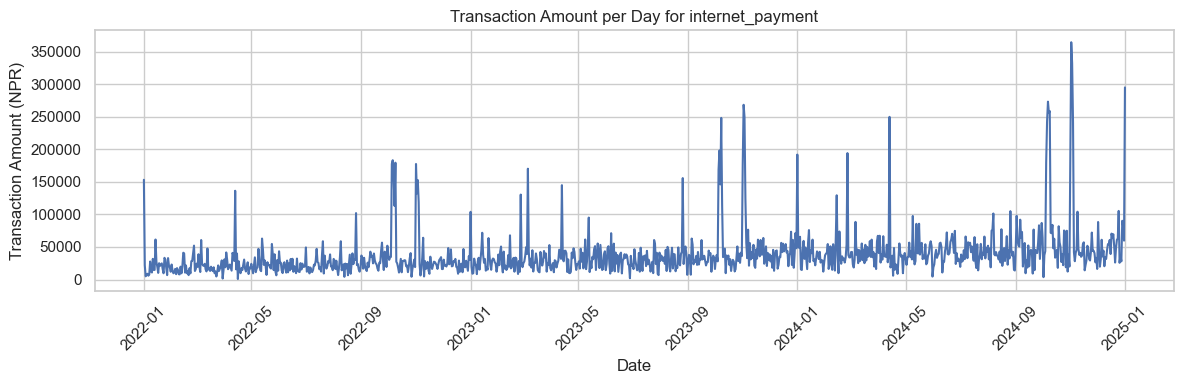

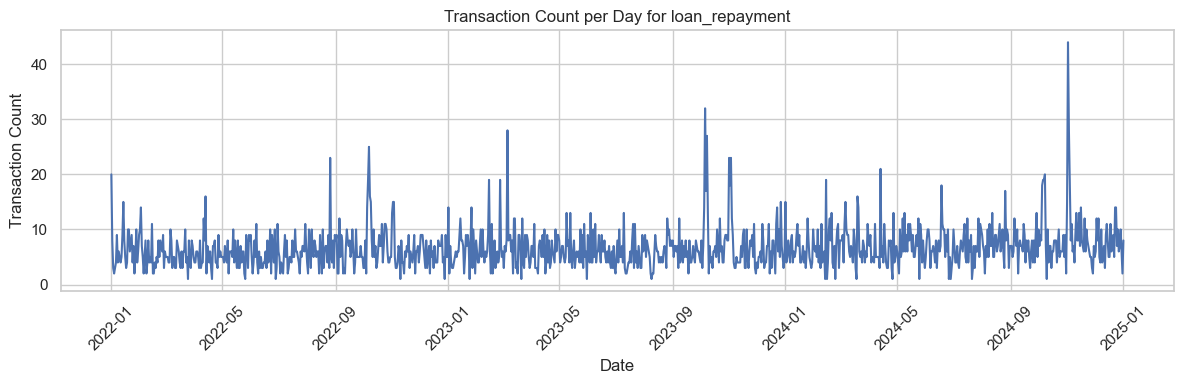

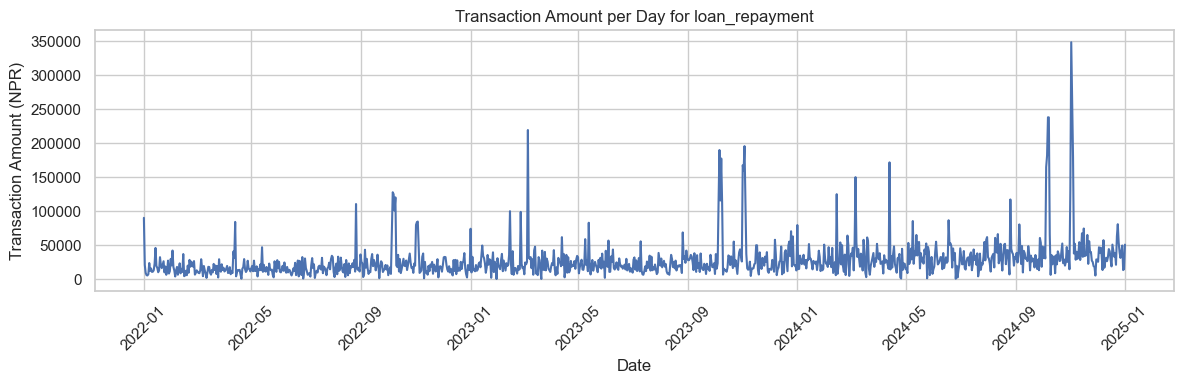

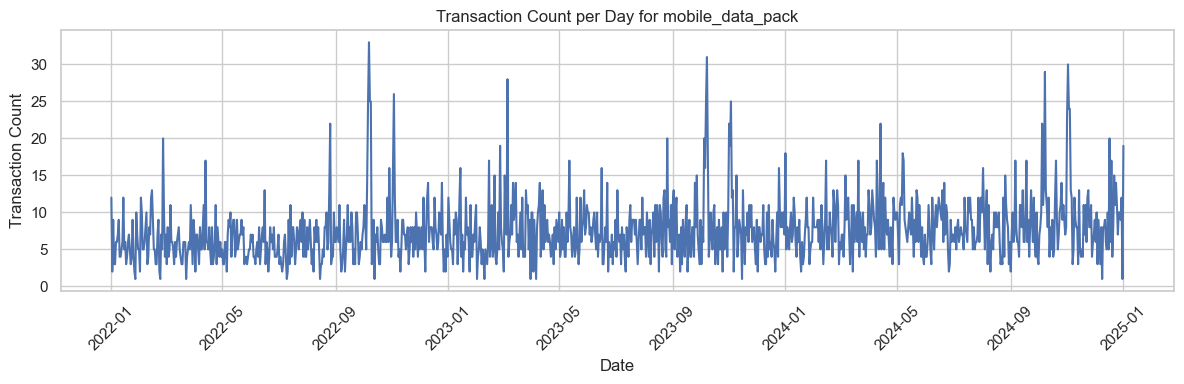

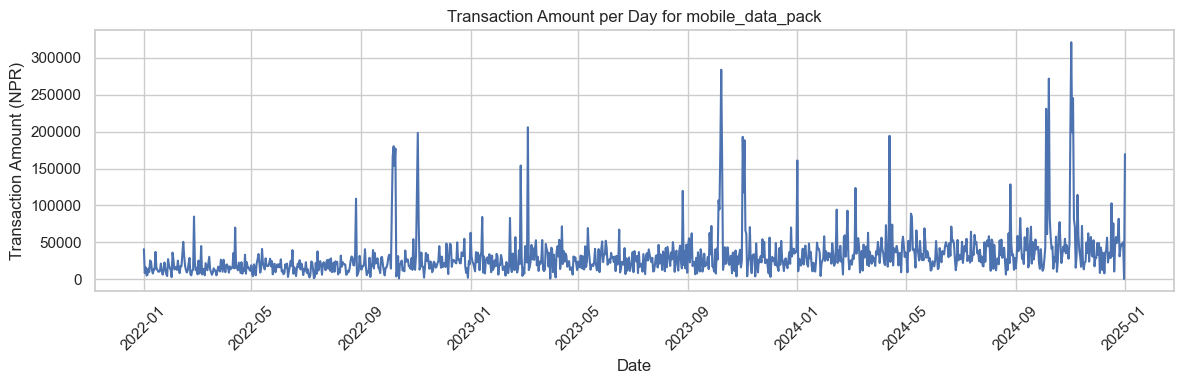

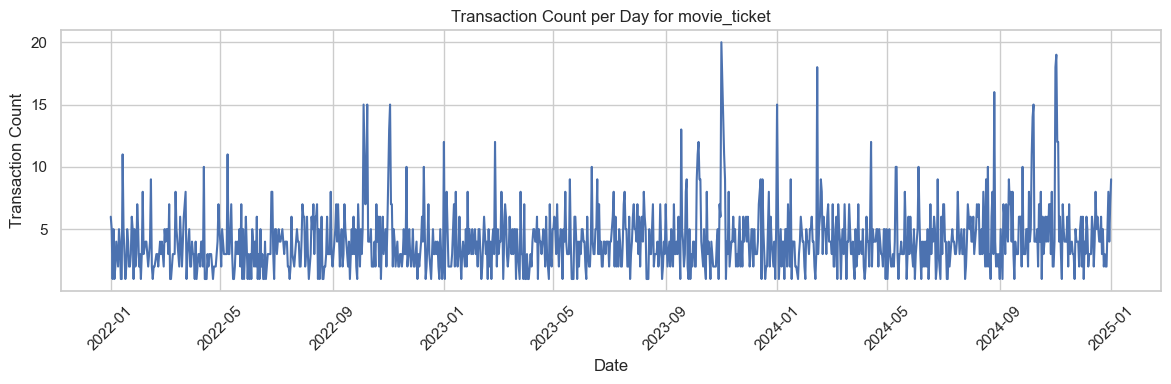

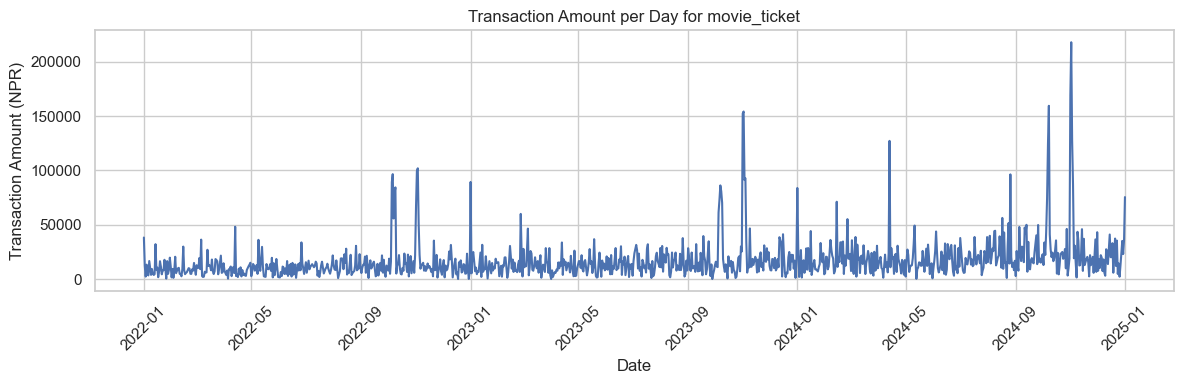

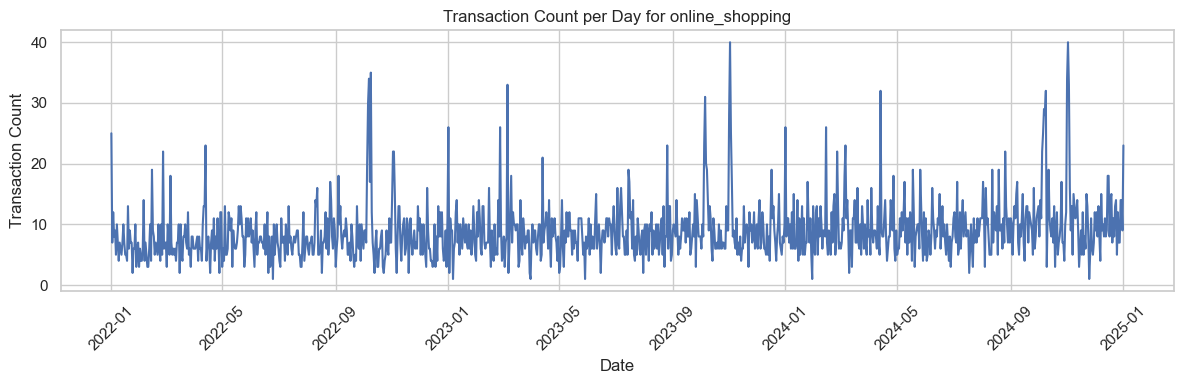

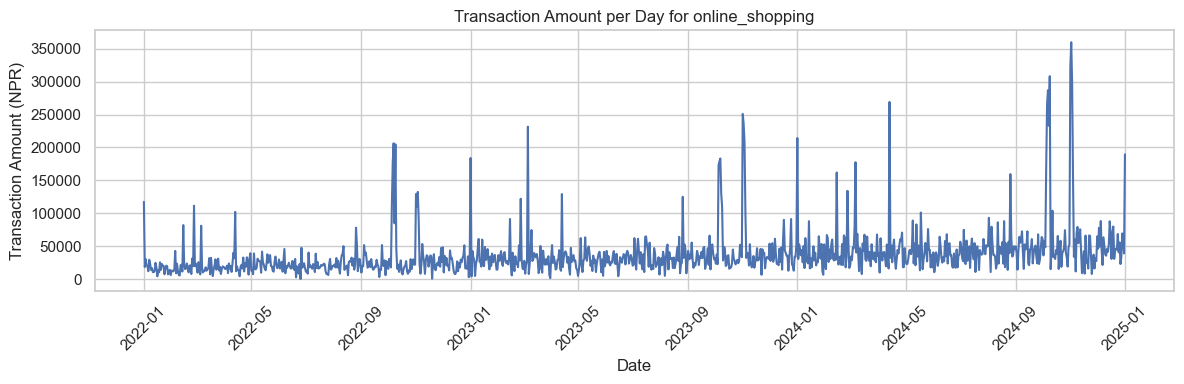

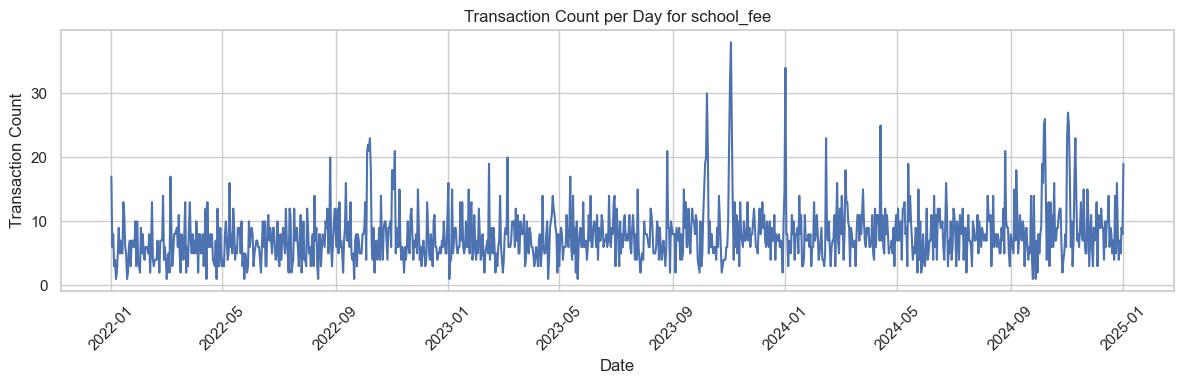

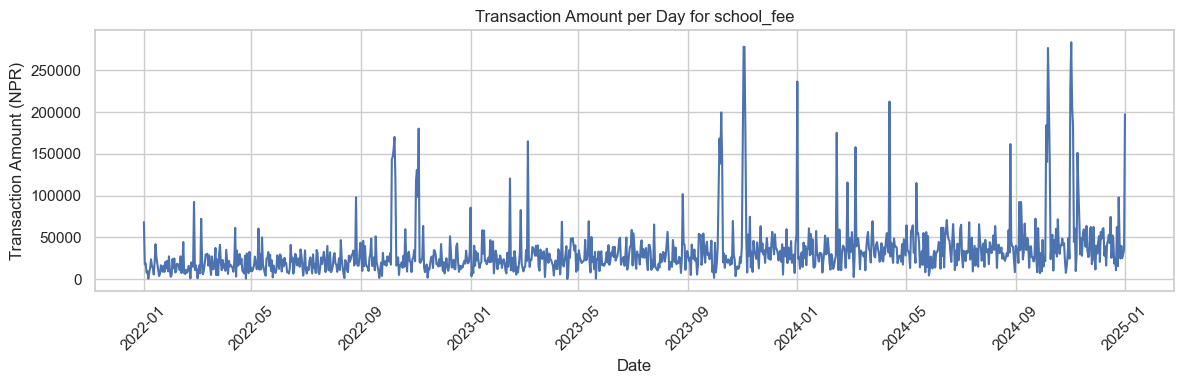

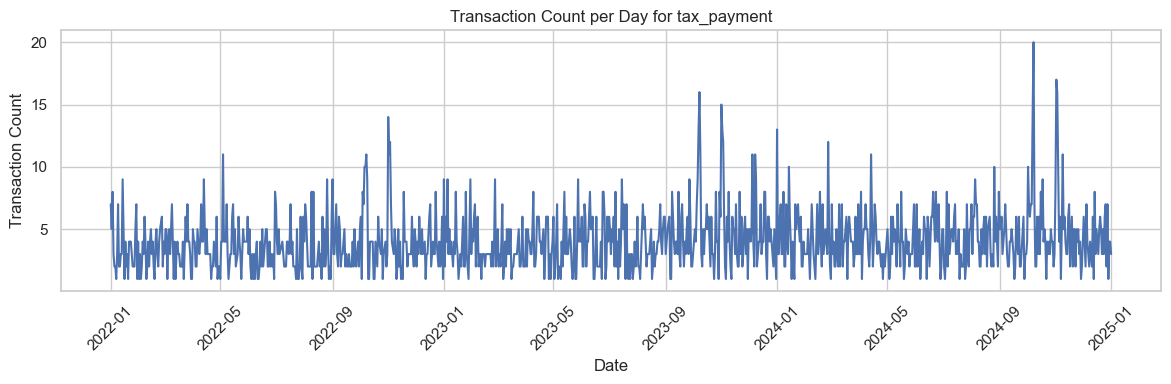

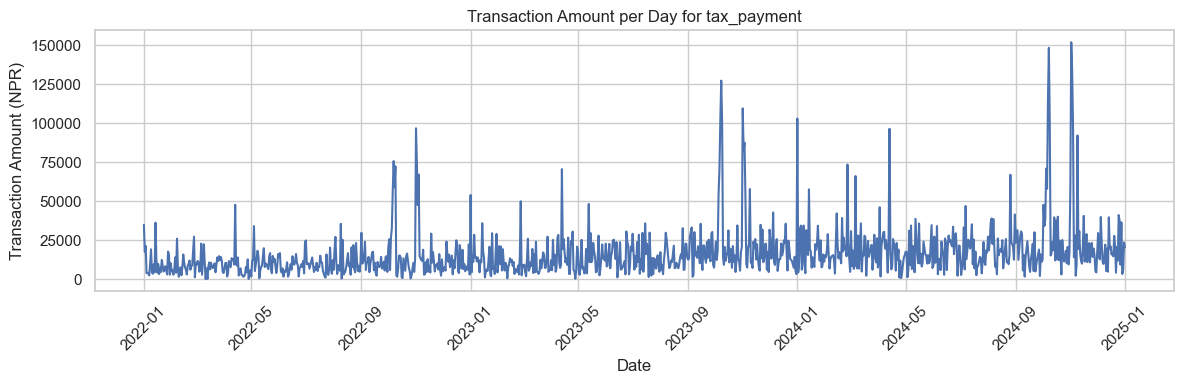

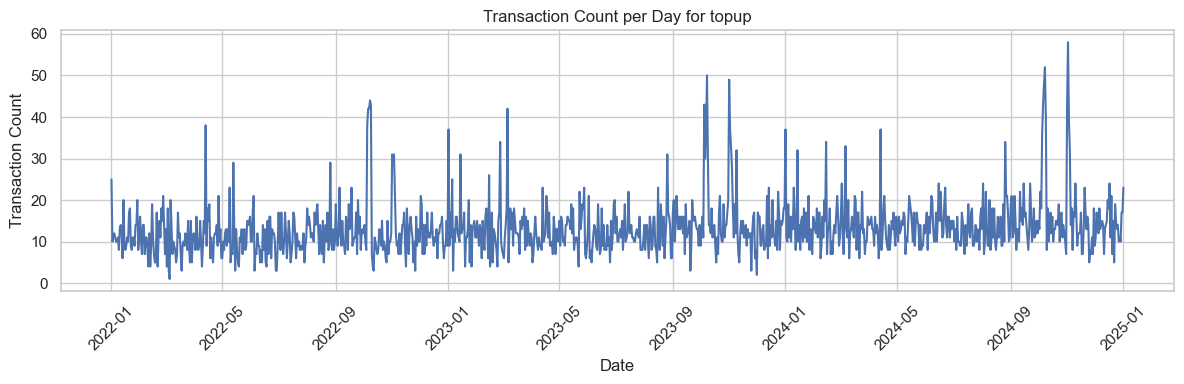

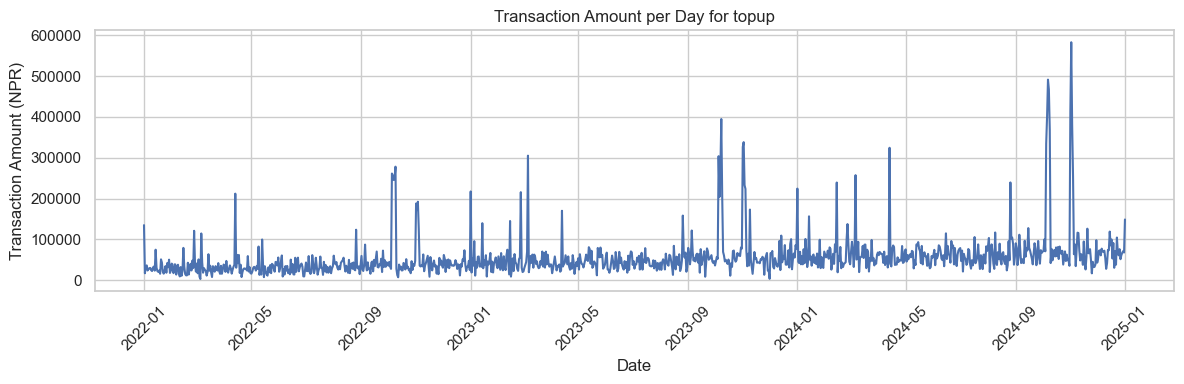

In [81]:
df.transaction_date = pd.to_datetime(df.transaction_date)
df.set_index('transaction_date', inplace=True)
df.sort_index(inplace=True)
df["service_category"] = df["service_category"].astype(str)

# Group by transaction_date and service_category
grouped = df.groupby(["transaction_date", "service_category"]).agg(
    transaction_count=("amount", "count"),
    transaction_amount=("amount", "sum")
).reset_index()

# Get unique categories
categories = grouped["service_category"].unique()

# Set plotting style
sns.set(style="whitegrid")

# Plot transaction count and amount separately for each category
for cat in categories:
    cat_data = grouped[grouped["service_category"] == cat]

    # Count Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cat_data, x="transaction_date", y="transaction_count")
    plt.title(f"Transaction Count per Day for {cat}")
    plt.xlabel("Date")
    plt.ylabel("Transaction Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Amount Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=cat_data, x="transaction_date", y="transaction_amount")
    plt.title(f"Transaction Amount per Day for {cat}")
    plt.xlabel("Date")
    plt.ylabel("Transaction Amount (NPR)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [76]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 0.01 * IQR

# Clip values
df['amount'] = df['amount'].clip(upper=upper_bound)
